# Data Exploration

The purpose of this notebook is to explore the Pokemon dataset by Vishalsubbiah and evaluate it regarding it's use for pokemon type classification.

With this exploration we aim to answer the following questions:
* What format is our data in?
* Is this data suitable for pokemon type classification?
* What are notable properties that are important for data preparation and machine learning?

For this purpose we will first download the dataset and then inspect the contained images and dataset.

But first let's get the imports out of the way.

In [1]:
# correct working directory.
# This is necessary for imports because the notebook is not in the main folder of the project. 
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

# external dependencies
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# same-project dependencies.
from data.dataset import Dataset

c:\Users\frank\Documents\Teaching\LU\Spring2023\Machine Learning² Unit\Machine Learning Example Project


## Download and Inspect Data

As a first step we download our data. The data is downloaded via the Kaggle API. The class *Dataset* manages this for us and takes care of downloading and managing the files of the dataset in the background. The first time we execute the following cell, it will take a bit longer, as the data will be downloaded. 

In [4]:
# Dataset wrapper automatically downloads data the first time we request it.
dataset = Dataset()

The dataset consists of two parts:
- A tabular dataset representing pokemon and their properties.
- A folder of pokemon images.

Let's first look at the dataset: 

In [5]:
data = dataset.get_original_data()
print("Total Pokémon:",len(data))
data.head()

Total Pokémon: 809


,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


As we can see, our dataset has 809 entries (one for each pokemon) and records the following three features:
*  **Name**: the name of the pokemon.
* **Type1**: the type of the pokemon.
* **Type2**: the second type of the pokemon. 

The connection to the image is done based on the name of the pokemon. 

The following cell can be run repeatedly to see different images.

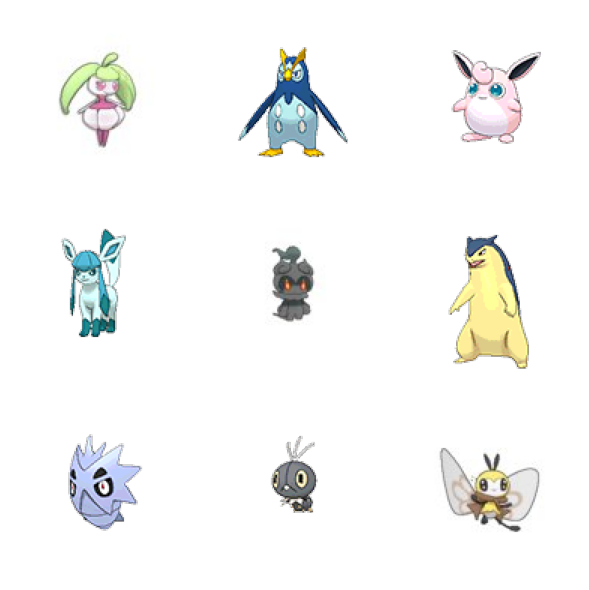

In [9]:
samples = data.sample(n=9)

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(3*2, 3*2))
for index in range(len(samples)):
    image = dataset.get_image(pokemon_name=samples.iloc[index]["Name"])
    axes[index//3][index%3].imshow(X=image) # type: ignore
    axes[index//3][index%3].axis('off')

plt.tight_layout()

## Image Data Properties

Here we observe the properties of the image data.

By manual inspection of our image data we can identify:
* Our images all have the same dimensions of 120 x 120.
* Our images come in two formats: .png and .jpg.  

Having different data formats indicates some adjustments will be needed. To illustrate this, we load "pikachu.png" and "pikipek.jpg".

In [14]:
pikachu_image = dataset.get_image(pokemon_name="pikachu")
pikachu_data = np.array(object=pikachu_image)
print("Pikachu shape:",pikachu_data.shape)

pikipek_image = dataset.get_image(pokemon_name="pikipek")
pikipek_data = np.array(object=pikipek_image)
print("Pikipek shape:",pikipek_data.shape)

Pikachu shape: (120, 120, 4)
Pikipek shape: (120, 120, 3)


As can be seen, both images have different numbers of color channels. Png are able to handle transparency and thus have a fourth alpha channel in addition to the red green and blue channel they share with jpgs. This forth channel seems to be used in our dataset. Png images have transparent background while jpg images have a white background. 

For data processing, we can identify the following two implications:
1) png and jpg images have different numbers of color channels.
2) png and jpg images have different background colors

## Tabular Data Properties

Here we look more closely at our tabular dataset. Our dataset is fairly basic and only contains three string parameters (two of which represent values of categorical variables). Missing values could be a concern for such a setup. Let's check this.

In [15]:
print("Missing Names:", data["Name"].isna().sum())
print("Missing Type1:", data["Type1"].isna().sum())
print("Missing Type2:", data["Type2"].isna().sum())

Missing Names: 0
Missing Type1: 0
Missing Type2: 404


Only the feature Type2 displays missing values. No names or primary types are missing. This is expected as not all pokmon have two types. This means, we will not have to fix this during data processing but will have to take this into account while designing the Machine Learning problem.


Another concern with this dataset is its balancedness. We should check which pokemon class is represented how often to check if our labels are balanced or skewed. For this purpose we plot the distribution of classes and also print out some information about the distribution in the following cell.

Number of classes: 18
Number of Samples: 1214
Average samples per class: 67.44444444444444
Minority class: Ice : 34
Majority class: Water : 131


<AxesSubplot: xlabel='Types', ylabel='Counts'>

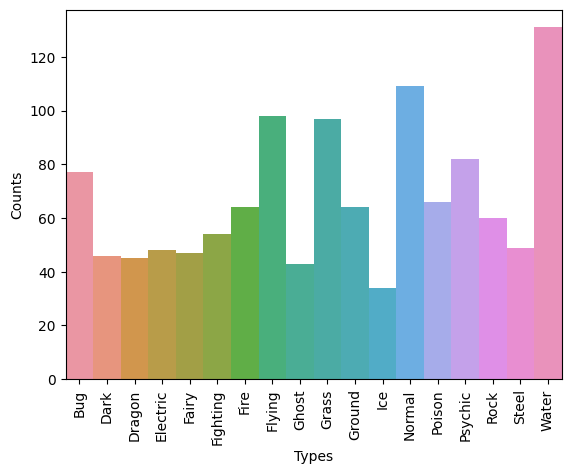

In [17]:
label_counts = {}

# Column Type1
labels, counts = np.unique(ar=data["Type1"], return_counts=True)

for index in range(len(labels)):
    label_counts[labels[index]] = counts[index]

# Column Type2
labels, counts = np.unique(
    ar=data[data["Type2"].notnull()]["Type2"], 
    return_counts=True
)
for index in range(len(labels)):
    if labels[index] in label_counts.keys():
        label_counts[labels[index]] += counts[index]
    else:
        label_counts[labels[index]] = counts[index]

# plot
plt.xlabel("Types")
plt.ylabel("Counts")
plt.xticks(rotation=90)

keys = list(label_counts.keys())
values = [label_counts[key] for key in keys]

# General statistics
print("Number of classes:", len(values))
print("Number of Samples:", sum(values))
print("Average samples per class:",sum(values)/len(values), end="\n")

# Minimum and maximum class
min_class = min(label_counts, key=label_counts.get)  # type: ignore
max_class = max(label_counts, key=label_counts.get)  # type: ignore

print("Minority class:", min_class, ":", label_counts[min_class])
print("Majority class:", max_class, ":", label_counts[max_class])

# Plot the distribution
sns.barplot(x=keys, y=values, width=1)


In the barplot we can identify that our dataset is slightly unbalanced. The majority class is "water" with 131 samples and the minority class is "ice" with 34 samples. While this is not perfect, it is also not extremely bad. Our majority class has about twice as many samples as the average class, while the minority class has about half as many as the average class. While we should keep this unbalanced nature in mind, the dataset is still usable for machine learning.

Another thing to note from this plot is that there seem to be no misspellings in our type columns (they would appear as additional categories in the plot).

## Summary

In summary, let's answer our  questions:

### What format is our data in?
Our dataset consists of 809 pokemon and records name, Type1 and Type2 for each pokemon. Type2 is not always set.
For each pokemon we have one image with dimensions 120x120.

### Is this data suitable for pokemon type classification?
The dataset contains pokemon types and images and is thus suitable for classifying pokemon types from images. 
There are some concerns with regards to the quantity of data:
* There are only about 800 entries.
* There only is one image per pokemon.
While we can't do anything about the first concern (without inventing more pokemon), there could be a way to add more images per pokemon by synthesizing other data sets. We will keep this in mind as a future work extension.


### What are notable properties that are important for data preparation and Machine Learning?
We identified the following factors that need to be taken into account:
1) Images have different numbers of color channels based on their formats (png has 4 and jpg has 3)
2) Images have different background colors based on their formats (png has transparent background and jpg has white background)
3) Column Type2 contains intended missing values because not all pokemon have two types.  
4) The dataset is somewhat unbalanced, but not extremely so. 